## Dataset
#### Allen Institute for Brain Science: Visual Coding - Neuropixels

© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels).

## Analyze running wheel data
Goal: segment epochs based on behavioral state  

Note on data acquisition:   
*Videos of the eye and body were acquired at 30 Hz. The angular velocity of the running wheel was recorded at the time of each stimulus frame, at approximately 60 Hz.*  
Source: [Technical White Paper](https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/80/75/8075a100-ca64-429a-b39a-569121b612b2/neuropixels_visual_coding_-_white_paper_v10.pdf)

##### Imports

In [1]:
# imports
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from fooof.core.funcs import gaussian_function
from scipy.optimize import curve_fit
from fooof.sim.gen import gen_periodic

from scipy import interpolate

##### Set up project 

In [2]:
# set manifest path and load project cache
MANIFEST_PATH = '/micha/visual_encoding/ecephys_cache_dir/'
project_cache = EcephysProjectCache.from_warehouse(manifest=join(MANIFEST_PATH, "manifest.json"))

##### Load data

In [3]:
# Select (and download) data for an example session
SESSION_ID = 791319847
session = project_cache.get_session_data(SESSION_ID)

In [4]:
# unpack running wheel data
data = session.running_speed
speed = data['velocity'].values
t_start = data['start_time'].values
t_end = data['end_time'].values

##### plot running speed on different timescales

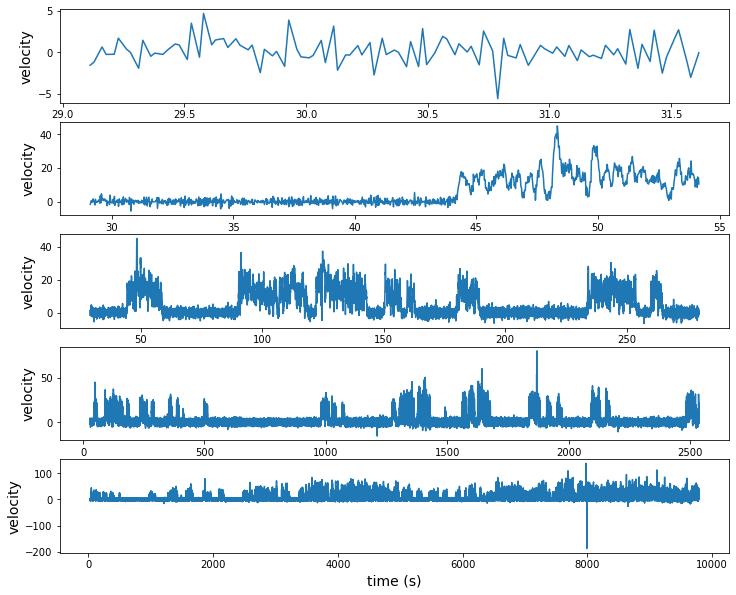

In [5]:
n_scales = int(np.floor(np.log10(len(speed))))
t = t_start

fig, axes = plt.subplots(n_scales,1, figsize=(12,n_scales*2))
for ii, ax in enumerate(axes):
    i_scale = ii+2
    ax.plot(t[:10**i_scale], speed[:10**i_scale])
    ax.set_xlabel('time (s)', fontsize=14)
    ax.set_ylabel('velocity', fontsize=14)

##### plot running speed over recorded intervals

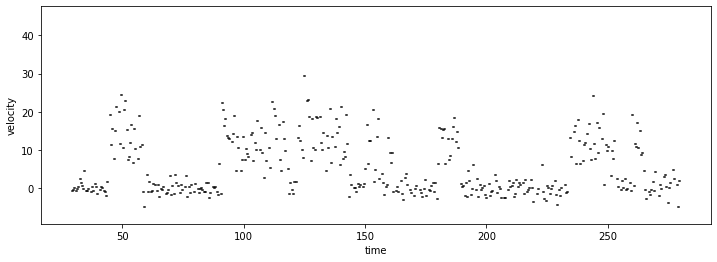

In [6]:
# number of samples to plot
N_SAMPLES = 10000

# plot
fig, ax = plt.subplots(figsize=(12,4))
for ii in range(N_SAMPLES):
    ax.plot([t_start[ii], t_end[ii]], [speed[ii], speed[ii]], color='k')
ax.set_xlabel('time')
ax.set_ylabel('velocity');

##### plot histogram of running speed

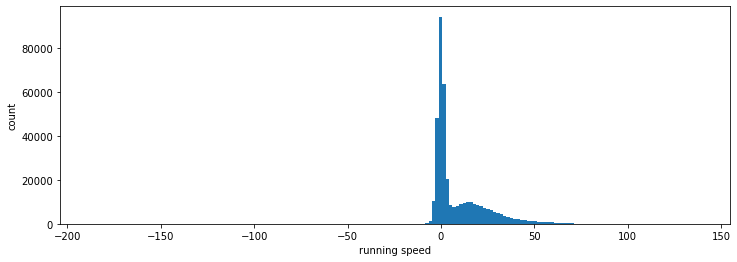

In [7]:
fig, ax = plt.subplots(figsize=[12,4])
counts, bin_edges, _ = ax.hist(speed,180)
ax.set_xlabel('running speed')
ax.set_ylabel('count');

##### fit running speed data (as 2 gaussian peaks)
using fooof functionality

Mean velocity:
    'stationary': 0.04
    'running': 16.28


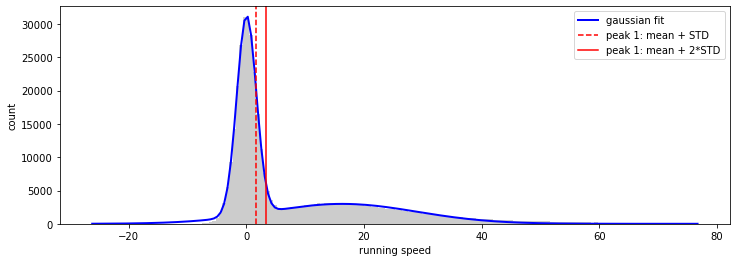

In [8]:
# remove outliers (any speeds 5 STD above the mean)
speed_clean = speed.copy()
speed_clean[speed>(speed.mean()+5*speed.std())] = 0
speed_clean[speed<(speed.mean()-5*speed.std())] = 0

# plot histogram
fig, ax = plt.subplots(figsize=[12,4])
counts, bin_edges, _ = ax.hist(speed_clean, 180, color='grey', alpha=0.4)

# determine center of histogram bins
bins = np.mean(np.vstack([bin_edges[:-1], bin_edges[1:]]), axis=0)

# use FOOOF functionality to fit peaks for 'stationary' and 'running' state
guess = (0,len(speed_clean)/2,speed_clean.std(), 
         np.max(speed_clean),len(speed_clean)/2,speed_clean.std())
popt, _ = curve_fit(gaussian_function, bins, counts, p0=guess)
fit = gen_periodic(bins, popt)
      
# plot fit
#ax.plot(bins, counts, color='k', linestyle='--', alpha=0.6, label='data')
ax.plot(bins, fit, color='b', linestyle='-', linewidth=2, label='gaussian fit')
thresh_1 = popt[0]+popt[2]
thresh_2 = popt[0]+2*popt[2]
ax.axvline(thresh_1, color='r', linestyle='--', label='peak 1: mean + STD')
ax.axvline(thresh_2, color='r', linestyle='-', label='peak 1: mean + 2*STD')
ax.legend()

# label plot
ax.set_xlabel('running speed')
ax.set_ylabel('count');

# print fit results
print('Mean velocity:')
print("    'stationary': %0.2f" %popt[0])
print("    'running': %0.2f" %popt[3])

##### Resample running speed data
Interpolate running speed to 60 Hz

The running wheel data interval duration (t_end - t_start) is consistant; therefor, the start time will be considered.  
The sampling rate takes two values: 60 Hz, as suggested by the Technical White Pages; and 30 Hz. This must be taken into account when downsampling

Mean running wheel sampling rate: 59.843739


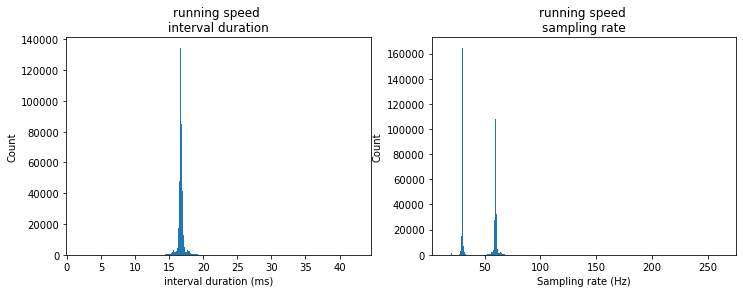

In [9]:
# determine consistancy of the sampling rate

# calc interval duration and sampling rate
dur = t_end-t_start
s_rate = 1 / np.diff(t_start)
print('Mean running wheel sampling rate: %f' %( 1 / dur.mean()))

fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=[12,4])
ax_1.hist(dur*1000, 300)
ax_1.set_title('running speed \ninterval duration')
ax_1.set_xlabel('interval duration (ms)')
ax_1.set_ylabel('Count')

ax_2.hist(s_rate, 300);
ax_2.set_title('running speed \nsampling rate')
ax_2.set_xlabel('Sampling rate (Hz)')
ax_2.set_ylabel('Count');

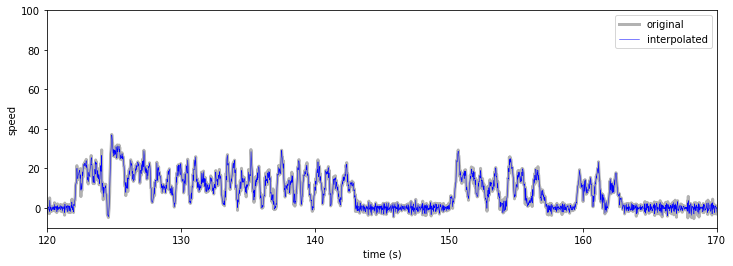

In [10]:
# interpolate data to 60 Hz

# create 1D linear interpolation function
flinear = interpolate.interp1d(t_start, speed_clean)

# define new time vector
n_seconds = int(np.ceil(np.max(t_start)) - np.floor(np.min(t_start)))
time = np.linspace(np.ceil(np.min(t_start)), np.floor(np.max(t_start)), n_seconds*60)

# interpolate running speed data
velocity = flinear(time)

# plot results
fig, ax = plt.subplots(figsize=[12,4])
ax.plot(t_start, speed, color='grey', linewidth=3, alpha=0.6, label='original')
ax.plot(time, velocity, color='b', linewidth=0.5, label='interpolated')
ax.set_xlim([120, 170])
ax.set_ylim([-10, 100])
#ax.axhline(thresh, color='r', linestyle='--', label='peak 1: mean + 3*STD')
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('speed');